In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [3]:

def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)


In [4]:
class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [5]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [136]:
def gen_test_data(stdev=0.1):
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, stdev, size=x.shape)

    return x, y + noise

x, y = gen_test_data(stdev=0.5)

In [137]:
import pugna.data

def preproc(data, method="MinMaxScaler", feature_range=(-1,1)):
    scalers = pugna.data.make_scalers(data, method=method, feature_range=feature_range)
    data_scaled = pugna.data.apply_scaler(data, scalers)
    return data_scaled, scalers

In [138]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import os



def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):

    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X >= xmin) & (X <= xmax)

    iy = IUS(X[mask], y[mask], k=k)

    Xnew = np.linspace(xmin, xmax, npts)

    return Xnew, iy(Xnew)


def download_and_load_data():
    if os.path.exists("scaled_data_to_fit.txt") is False:
        os.system(
            "curl https://gitlab.com/SpaceTimeKhantinuum/ml/-/raw/master/nn-fitting/1d-fitting/scaled_data_to_fit.txt -O "
        )

    Xy = np.loadtxt("scaled_data_to_fit.txt")
    # sort by X
    X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T

    return X_raw, y_raw


x, y = download_and_load_data()

# x, y = resample_data(x, y, xmin=None, xmax=None, npts=45, k=1)
# x, y = resample_data(x, y, xmin=None, xmax=None, npts=150, k=1)
x, y = resample_data(x, y, xmin=None, xmax=None, npts=350, k=1)

x = x[:, np.newaxis]
y = y[:, np.newaxis]





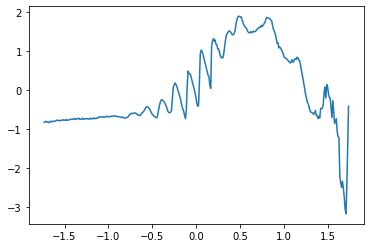

In [139]:
plt.figure()
plt.plot(x, y)
plt.show()
plt.close()

In [182]:
def get_base_model(x, y, verbose=True, batch_size=None, epochs=1000):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        ExU(2000),
        tf.keras.layers.Dense(400, activation='tanh', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
        tf.keras.layers.Dense(400, activation='tanh', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [230]:
def get_later_model(x, y, verbose=True, batch_size=None, epochs=1000):
    if batch_size is None:
        batch_size = x.shape[0]

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        ExU(2000),
#         tf.keras.layers.Dense(600, activation='relu', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
#         tf.keras.layers.Dense(600, activation='relu', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return history, model

In [184]:
%%time
history1, model1 = get_base_model(x, y, epochs=2000)

Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.4964
Epoch 2/2000
1/1 [==============================] - 0s 970us/step - loss: 15.9832
Epoch 3/2000
1/1 [==============================] - 0s 825us/step - loss: 1.2441
Epoch 4/2000
1/1 [==============================] - 0s 915us/step - loss: 5.1011
Epoch 5/2000
1/1 [==============================] - 0s 978us/step - loss: 1.6704
Epoch 6/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6866
Epoch 7/2000
1/1 [==============================] - 0s 740us/step - loss: 1.5792
Epoch 8/2000
1/1 [==============================] - 0s 577us/step - loss: 1.5791
Epoch 9/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.9356
Epoch 10/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6548
Epoch 11/2000
1/1 [==============================] - 0s 977us/step - loss: 0.8710
Epoch 12/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.0069
Epoch 13/2000
1/1 [===============

In [185]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ex_u_17 (ExU)                (None, 2000)              4000      
_________________________________________________________________
dense_55 (Dense)             (None, 400)               800400    
_________________________________________________________________
dense_56 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 401       
Total params: 965,201
Trainable params: 965,201
Non-trainable params: 0
_________________________________________________________________


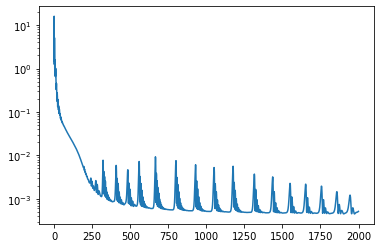

In [186]:
h1 = history1.history['loss']
plt.figure()
plt.plot(range(len(h1)), h1)
plt.yscale('log')

In [187]:
yhat = model1.predict(x) 

In [188]:
yRes = y-yhat 

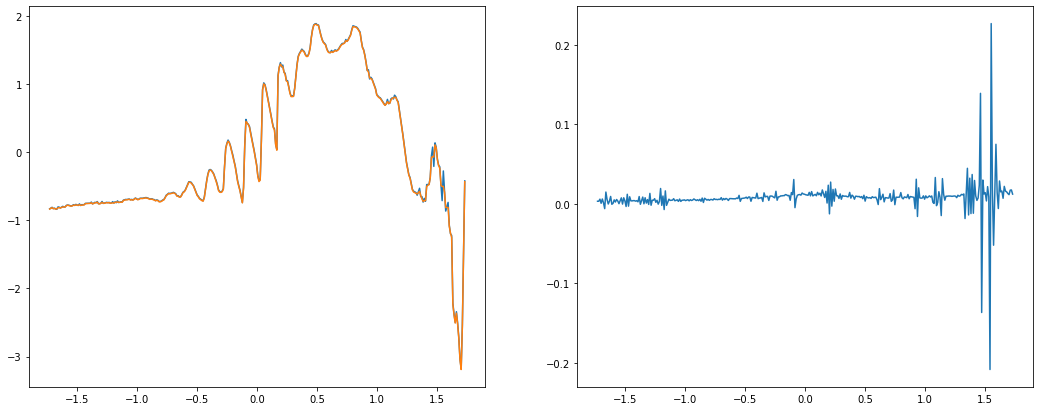

In [189]:
plot_prediction_and_error(x, y, model1) 

(1e-18, 1)

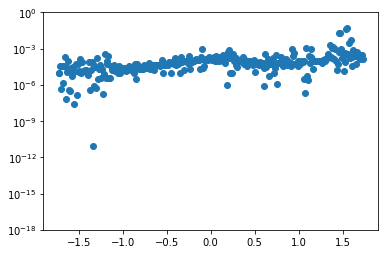

In [190]:
plt.figure()
plt.scatter(x, tf.keras.losses.mean_squared_error(y, yhat) )
plt.yscale('log')
plt.ylim(1e-18, 1)

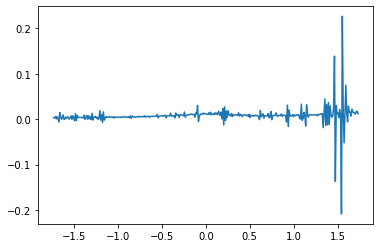

In [231]:
plt.figure()
plt.plot(x, yRes)

In [232]:
yRes, scalers2 = preproc(yRes)

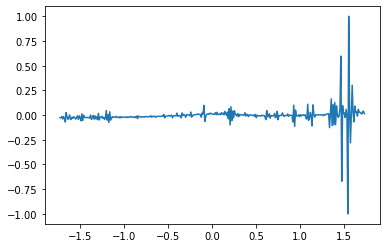

In [233]:
plt.figure()
plt.plot(x, yRes)

In [234]:
%%time
# history2, model2 = get_base_model(x, yRes, False, epochs=1000)
history2, model2 = get_later_model(x, yRes, False, epochs=1000)

CPU times: user 11.6 s, sys: 9.82 s, total: 21.5 s
Wall time: 4.87 s


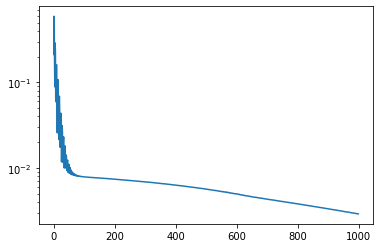

In [235]:
h2 = history2.history['loss']
plt.figure()
plt.plot(range(len(h2)), h2)
plt.yscale('log')

In [236]:
yhat2 = model2.predict(x)

In [237]:
yRes = pugna.data.apply_inverse_scaler(yRes, scalers2)
yhat2 = pugna.data.apply_inverse_scaler(yhat2, scalers2)

In [238]:
yRes2 = yRes-yhat2 

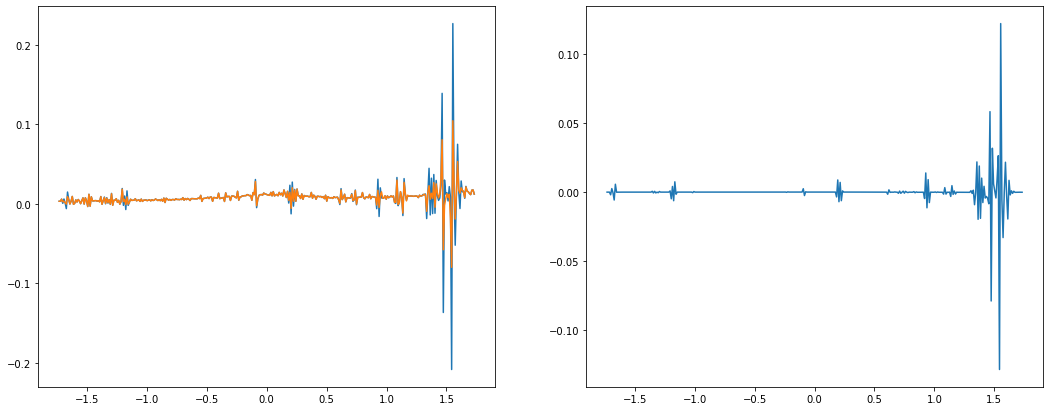

In [239]:
plot_prediction_and_error(x, yRes, yhat=yhat2) 

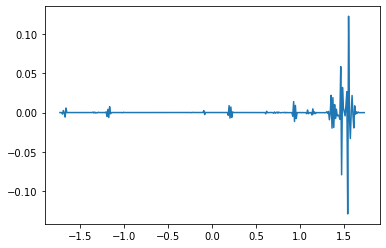

In [240]:
plt.figure()
plt.plot(x, yRes2)

In [248]:
yRes2, scalers3 = preproc(yRes2)

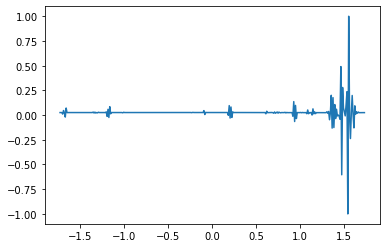

In [249]:
plt.figure()
plt.plot(x, yRes2)

In [250]:
%%time
history3, model3 = get_later_model(x, yRes2, False, epochs=2000)

CPU times: user 23 s, sys: 19.2 s, total: 42.1 s
Wall time: 9.22 s


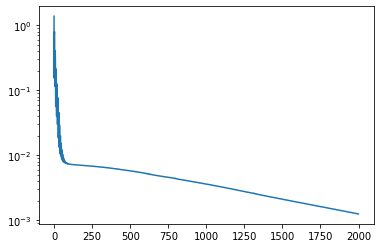

In [251]:
h3 = history3.history['loss']
plt.figure()
plt.plot(range(len(h3)), h3)
plt.yscale('log')

In [252]:
yhat3 = model3.predict(x)

In [253]:
yRes2 = pugna.data.apply_inverse_scaler(yRes2, scalers3)
yhat3 = pugna.data.apply_inverse_scaler(yhat3, scalers3)

In [254]:
yRes3 = yRes2-yhat3

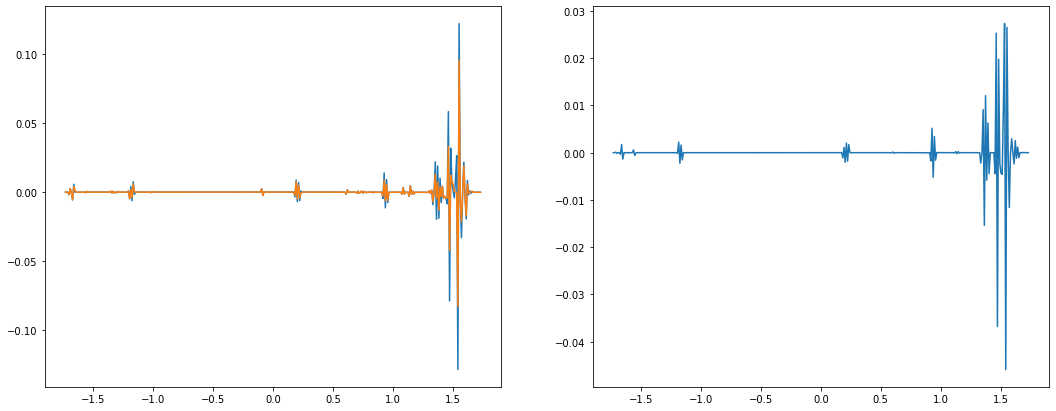

In [255]:
plot_prediction_and_error(x, yRes2, yhat=yhat3) 

In [256]:
# yhat_multistep = model1.predict(x) + model2.predict(x) # + model3.predict(x)
# yhat_multistep = model1.predict(x) + pugna.data.apply_inverse_scaler(model2.predict(x), scalers2)
yhat_multistep = model1.predict(x) \
    + pugna.data.apply_inverse_scaler(model2.predict(x), scalers2) \
    + pugna.data.apply_inverse_scaler(model3.predict(x), scalers3)

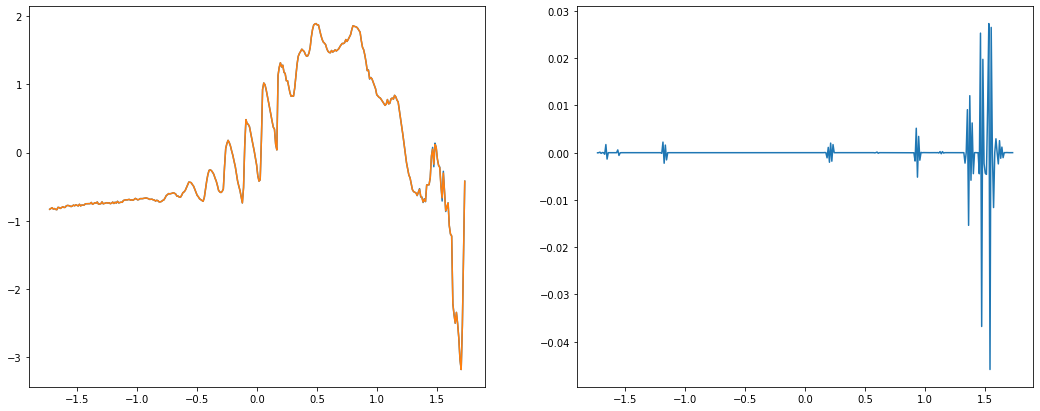

In [257]:
plot_prediction_and_error(x, y, model=None, yhat=yhat_multistep) 

In [258]:
yhat_multistep_loss = tf.keras.losses.mean_squared_error(y, yhat_multistep) 

(1e-14, 1)

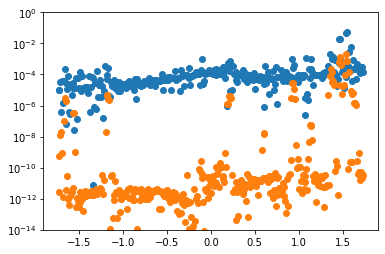

In [259]:
plt.figure()
plt.scatter(x, tf.keras.losses.mean_squared_error(y, yhat) )
plt.scatter(x, yhat_multistep_loss)
plt.yscale('log')
plt.ylim(1e-14, 1)